In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

A function can be represented by function values at a number of points. If we draw these values from a standard Gaussian distribution, it will look like this:

In [2]:
N = 50
x = np.linspace(-8, 8, N) #[:, np.newaxis]

mu = np.zeros((N))
C = np.eye(N)

rv_samples = multivariate_normal(mu, C).rvs(size=5)

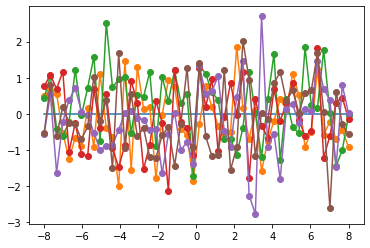

In [3]:
plt.plot(x, mu)
plt.plot(x, rv_samples.T, "o-");

If we now specify a special covariance matrix, the result will look rather different. 

In [4]:
C = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        C[i,j] = 10. * np.exp(-1. * (x[i] - x[j])**2)

# to make sure, C is positive definite, we can add a small value to the diagonal
C = C + 0.001*np.eye(N)

In [ ]:
# vectorized version:
C = 10.*np.exp(-1.*np.power((x[:,np.newaxis] - x[np.newaxis,:]), 2)) + 0.001 * np.eye(N)

We can draw samples from any Gaussian distribution by transforming a standard Gaussian using the following formula:

$$ \mathcal{N}(x; \mu, \sigma^2) = \mu + \sigma \cdot \mathcal{N}(x; 0, 1) $$


In the multivariate case, the same can be done by using Cholesky factorization:

$$ \Sigma = LL^T $$

$$ \mathcal{N}(\boldsymbol x; \boldsymbol \mu, \boldsymbol \Sigma) = \boldsymbol \mu + L \cdot \mathcal{N}(\boldsymbol x; \boldsymbol 0, \boldsymbol 1) $$

In [ ]:
# from the normal distribution (mu,C) a random vector can be drawn by using Cholesky factorization:
L = np.linalg.cholesky(C)
z = np.random.normal(0,1, (len(mu), 5))

rv_samples2 = L @ z #+ mu[:, np.newaxis]
rv_samples2.shape

In [ ]:
plt.plot(x, mu, color="grey")
plt.plot(x, rv_samples2, "o-");

By computing the covariance matrix this way, the 'function samples' 
The function used to compute the covariance matrix is called RBF kernel function (other names for the same function are Squared Exponential (SE) or Gaussian)

In [ ]:
fig = plt.figure(figsize=(16,16))

for i, length_scale in enumerate([1e-1, 0.5, 1., 1.5, 2., 3., 5., 1e01]):
    C = np.exp(-np.power((x[:,np.newaxis] - x[np.newaxis,:]) / length_scale, 2)) + 0.0001 * np.eye(N)
    
    rv = multivariate_normal(mu, C)
    L = np.linalg.cholesky(C)
    z = np.random.normal(0, 1, (len(mu), 5))
    rv_samples = L @ z #+ mu[:, np.newaxis]
    
    ax = fig.add_subplot(4, 2, i+1)
    ax.plot(x, mu, color="grey")
    ax.plot(x, rv_samples, "o-")
    ax.set_title(f"length_scale = {length_scale}")

### _=> Priors in function space can be specified by using a kernel function_

In [ ]:
N_grid = 50
xmin = 0
xmax = 1

x = np.linspace(xmin, xmax, N_grid)

In [ ]:
def f(x, noise_lvl=0.):
    return (6*x - 2)**2 * np.sin(12*x - 4) + np.random.normal(0, 1, x.shape)*noise_lvl

# Training Data
N_data = 20
x_data = np.sort(np.random.rand(N_data)*(xmax-xmin) + xmin)
X = x_data = x_data[:, np.newaxis]


Y = y_data = f(x_data[:,0], 0.5)[:, np.newaxis]

plt.plot(x_data, y_data, 'o', label="data points")
plt.plot(x, f(x), '-', label="true function")
plt.gca().set_title("Forrester function")
plt.legend()

In [ ]:
def rbf_kernel(xa, xb, length_scale=1., var=1.):
    K = np.zeros((len(xa), len(xb)))
    for i,u in enumerate(xa):
        for j,v in enumerate(xb):
            d = u - v            
            K[i,j] = - np.dot(d, d/length_scale)
        
    return var**2 * np.exp(K)

In [ ]:
length_scale = 0.01
var = 1.
sigma = 0.5

k_xx = rbf_kernel(x, x, length_scale, var)
k_XX = rbf_kernel(x_data, x_data, length_scale, var)
k_xX = rbf_kernel(x, x_data, length_scale, var)
k_Xx = k_xX.T

In [ ]:
# warning: this operation might become unstable for some covariance matrices

C_inv = np.linalg.inv(k_XX + sigma*np.eye(N_data))

mu_post = k_xX @ C_inv @ Y

cov_post = k_xx - k_xX @ C_inv @ k_Xx
std_post = np.sqrt(np.diag(cov_post))

In [ ]:
# a more stable alternative:

a = np.linalg.solve(k_XX + sigma*np.eye(N_data), k_xX.T).T

mu_post = a @ Y

cov_post = k_xx - a @ k_Xx
std_post = np.sqrt(np.diag(cov_post))

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(x_data, y_data, 'o', label="data points")
plt.plot(x, mu_post, '-', label="mean prediction")
plt.plot(x, f(x), '-', label="true function")

y_upper = mu_post + 2*std_post
y_lower = mu_post - 2*std_post
plt.fill_between(x, y_upper[:,0], y_lower[:,0], alpha=0.2, label="95% CI")

plt.legend()

### Warning: The following code might be numerically unstable. It's only intended for educational purposes!

In [ ]:
def mll(args):
    length_scale_exponent, var_exponent = args
    
    length_scale = np.power(10, length_scale_exponent)
    var = np.power(10, var_exponent)
    
    k_XX = rbf_kernel(x_data, x_data, length_scale, var)
    
    return multivariate_normal(np.zeros((N_data)), k_XX + sigma * np.eye(N_data)).logpdf(y_data).sum()


In [ ]:
var_exponent_values = np.linspace(-4, 4, 20)
length_scale_exponent_values = np.linspace(-5, -2, 20)

mll_values = np.zeros((20,20))


for i, ls_exp in enumerate(length_scale_exponent_values):
    for j, var_exp in enumerate(var_exponent_values):
        #print(ls_exp, var_exp)
        mll_values[i,j] = mll((ls_exp, var_exp))

In [ ]:
fig, ax = plt.subplots()
cf = ax.contourf(length_scale_exponent_values, var_exponent_values, mll_values)
fig.colorbar(cf, ax=ax)
ax.set_xlabel("Log Length Scale")
ax.set_ylabel("Log Variance")
ax.set_title("Marginal Log-Likelihood")

In [ ]:
imax = np.argmax(mll_values)
i,j = np.unravel_index(imax, mll_values.shape)
print(i, j, mll_values[i,j])

In [ ]:
length_scale_exponent = length_scale_exponent_values[i]
var_exponent = var_exponent_values[j]

length_scale = np.power(10, length_scale_exponent)
var = np.power(10, var_exponent)

length_scale, var

In [ ]:
k_xx = rbf_kernel(x, x, length_scale, var)
k_XX = rbf_kernel(x_data, x_data, length_scale, var)
k_xX = rbf_kernel(x, x_data, length_scale, var)
k_Xx = k_xX.T

a = np.linalg.solve(k_XX + sigma*np.eye(N_data), k_xX.T).T
mu_post = a @ Y

cov_post = k_xx - a @ k_Xx
std_post = np.sqrt(np.diag(cov_post))

plt.figure(figsize=(16,8))
plt.plot(x_data, y_data, 'o', label="data points")
plt.plot(x, mu_post, '-', label="mean prediction")
plt.plot(x, f(x), '-', label="true function")

y_upper = mu_post + 2*std_post
y_lower = mu_post - 2*std_post
plt.fill_between(x, y_upper[:,0], y_lower[:,0], alpha=0.2, label="95% CI")

plt.legend()